In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers


import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting
from bokeh.layouts import column, row
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
bokeh.io.output_notebook()

ModuleNotFoundError: No module named 'tensorflow'

In [64]:
def plot_results(history):
    tools = [PanTool(), WheelZoomTool(), ResetTool(), HoverTool()]
    p = bokeh.plotting.figure(title='Training and validation loss', tools=tools)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    p.line(epochs, loss, color='blue', legend_label='Training loss')
    p.line(epochs, val_loss, color='red', legend_label='Validation loss')
    p.yaxis.axis_label = "Loss"
    p.xaxis.axis_label = 'Epochs'
    p.legend.click_policy="hide"
    p.legend.visible=False

    q = bokeh.plotting.figure(title='Training and validation accuracy', tools=tools)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    q.line(epochs, acc, color='blue', legend_label='training')
    q.line(epochs, val_acc, color='red', legend_label='validation')
    q.yaxis.axis_label = "Accuracy"
    q.xaxis.axis_label = 'Epochs'
    q.legend.click_policy="hide"
    q.legend.location="bottom_right"
    bokeh.io.show(row(p, q))

In [16]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [17]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                               'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                               'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                               'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                               'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                               'WI', 'WV', 'WY'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                           'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                           'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                           'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                           'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                           'WI', 'WV', 'WY'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)

def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

In [30]:
X_train_full,X_test,Y_train_full=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

# def over_under_sampling(X_train,Y_train,method,fraction):
#     if method=="randomU":
#         rus = RandomUnderSampler(random_state=0,sampling_strategy=fraction)
#     elif method=="randomO":
#         rus = RandomOverSampler(random_state=0,sampling_strategy=fraction)
#     elif method=="centroid":
#         rus = ClusterCentroids(random_state=42,sampling_strategy=fraction)
#     elif method=="SMOTENN":
#         rus = SMOTEENN(random_state=42,sampling_strategy=fraction)
#     X_resampled, y_resampled = rus.fit_resample(X_train, Y_train)
#     return X_resampled, y_resampled

# X_train, Y_train = over_under_sampling(X_train,Y_train,"randomO",0.5)




## LGBM Classifier

In [38]:
lgbm_clf = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf.fit(X_train, Y_train)
Y_train_pred_lgbm=lgbm_clf.predict(X_train)
Y_val_pred_lgbm=lgbm_clf.predict(X_val)
Y_val_pred_prob_lgbm=lgbm_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm)

0.6922932719829431

In [39]:
Y_train_pred_prob_lgbm=lgbm_clf.predict_proba(X_train)[:,1]


In [40]:
confusion_matrix(Y_val,Y_val_pred_lgbm)

array([[20981, 12367],
       [ 2142,  3960]])

In [41]:
np.std(Y_val_pred_prob_lgbm)

0.16849686598232874

## Random Forest Classifier 

In [42]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf.fit(X_train, Y_train)
Y_train_pred_rf=rf_clf.predict(X_train)
Y_val_pred_rf=rf_clf.predict(X_val)
Y_val_pred_prob_rf=rf_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf)

0.6906940297301636

In [43]:
Y_train_pred_prob_rf=rf_clf.predict_proba(X_train)[:,1]


In [44]:
confusion_matrix(Y_val,Y_val_pred_rf)

array([[25770,  7578],
       [ 3202,  2900]])

In [45]:
np.std(Y_val_pred_prob_rf)

0.15276028123469826

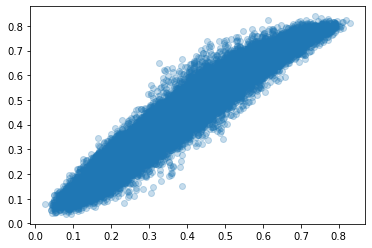

In [46]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_lgbm, alpha=0.25)


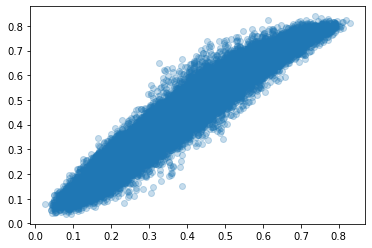

In [47]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_lgbm, alpha=0.25)





In [48]:
rf_clf_max_samples = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=200, max_samples=0.3)
rf_clf_max_samples.fit(X_train, Y_train)
Y_train_pred_rf_max=rf_clf_max_samples.predict(X_train)
Y_val_pred_rf_max=rf_clf_max_samples.predict(X_val)
Y_val_pred_prob_rf_max=rf_clf_max_samples.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf_max)

0.6884598701841593

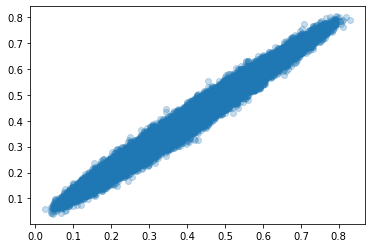

In [49]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_rf_max, alpha=0.25)

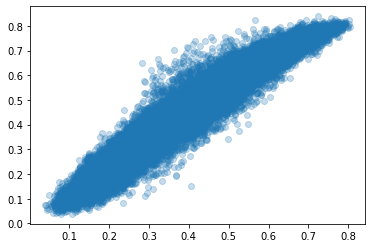

In [50]:
plt.scatter(Y_val_pred_prob_rf_max, Y_val_pred_prob_lgbm, alpha=0.25)

In [51]:
rf_clf_max_samples2 = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=10, n_estimators=200, max_samples=0.3)
rf_clf_max_samples2.fit(X_train, Y_train)
Y_train_pred_rf_max2=rf_clf_max_samples2.predict(X_train)
Y_val_pred_rf_max2=rf_clf_max_samples2.predict(X_val)
Y_val_pred_prob_rf_max2=rf_clf_max_samples2.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf_max2)

0.6854036534642555

In [52]:
rf_clf_max_samples2 = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=10, n_estimators=80, max_samples=0.3)
rf_clf_max_samples2.fit(X_train, Y_train)
Y_train_pred_rf_max2=rf_clf_max_samples2.predict(X_train)
Y_val_pred_rf_max2=rf_clf_max_samples2.predict(X_val)
Y_val_pred_prob_rf_max2=rf_clf_max_samples2.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf_max2)

0.6836428991892535

## Adaboost Classifier

In [53]:
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_train, Y_train, sample_weight=copy.deepcopy(Y_train)*4 + 1)
Y_train_pred_ada=ada_clf.predict(X_train)
Y_val_pred_ada=ada_clf.predict(X_val)
Y_val_pred_prob_ada=ada_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_ada)

0.686442191099633

In [54]:
Y_train_pred_prob_ada=ada_clf.predict_proba(X_train)[:,1]


In [55]:
confusion_matrix(Y_val,Y_val_pred_ada)

array([[22313, 11035],
       [ 2431,  3671]])

In [56]:
np.std(Y_val_pred_prob_ada)

0.0023487612828071856

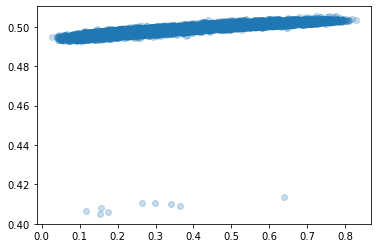

In [57]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_ada, alpha=0.25)

### Blend into an ensemble 
doesn't work very well.. hmmm

In [59]:
X_blend=np.concatenate((X_train, Y_train_pred_prob_lgbm.reshape(-1, 1), Y_train_pred_prob_rf.reshape(-1, 1)), axis=1)
X_blend_val=np.concatenate((X_val, Y_val_pred_prob_lgbm.reshape(-1, 1), Y_val_pred_prob_rf.reshape(-1, 1)), axis=1)


In [65]:

network = models.Sequential()
network.add(layers.Dense(100, activation="leaky_relu", input_shape=(X_blend.shape[1],)))
network.add(layers.Dropout(0.15))
network.add(layers.Dense(10, activation="leaky_relu"))
network.add(layers.Dense(2, activation="softmax"))
network.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history = network.fit(X_blend, Y_train, batch_size=16, epochs=10, validation_split=0.2, shuffle=True, verbose=False)

test_loss, test_acc = network.evaluate(X_blend_val, Y_val)
print('the final accuracy on the holdout set was ', np.round(test_acc * 100, 2), '%')

y_pred_prob_nn = network.predict(X_val)
y_pred_nn = network.predict(X_train)
y_pred_nn[y_pred_nn>=0.5] = 1
y_pred_nn[y_pred_nn<0.5] = 0
y_val_pred_nn = network.predict(X_val)
y_val_pred_nn[y_val_pred_nn>=0.5] = 1
y_val_pred_nn[y_val_pred_nn<0.5] = 0
print("ROC AUC score: ", roc_auc_score(y_val_oh, y_pred_prob_nn))

NameError: name 'models' is not defined

In [ ]:
plot_results(history)

In [60]:
clf = LogisticRegression(random_state=0).fit(X_blend, Y_train)
Y_val_pred_prob=clf.predict_proba(X_blend_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

/Users/glchau/opt/anaconda3/envs/bebi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6351576594400725

In [61]:
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_blend, Y_train)
Y_val_pred_prob=clf.predict_proba(X_blend_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

/Users/glchau/opt/anaconda3/envs/bebi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6392569471988864

## Use average voting

In [62]:
Y_average = np.mean([Y_val_pred_prob_lgbm,Y_val_pred_prob_rf,Y_val_pred_prob_ada], axis=0)

print(AUC_score(Y_val,Y_average))

Y_average[Y_average>=0.5] = 1
Y_average[Y_average<0.5] = 0
confusion_matrix(Y_val,Y_average)

0.6923142951811134


array([[23474,  9874],
       [ 2626,  3476]])

## Output to submission

In [78]:
lgbm_clf_full = LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60, n_estimators=80)
lgbm_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm=lgbm_clf_full.predict_proba(X_test)[:,1]


rf_clf_full = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_rf=rf_clf_full.predict_proba(X_test)[:,1]

test_probs = [Y_test_pred_prob_lgbm,Y_test_pred_prob_rf]

for n_est in [80, 100, 120]: 
    lgbm_clf_full = LGBMClassifier(class_weight='balanced', max_depth=11-5, min_child_samples=60+10, n_estimators=n_est)
    lgbm_clf_full.fit(X_train_full, Y_train_full)
    Y_test_pred_prob_lgbm=lgbm_clf_full.predict_proba(X_test)[:,1]
    test_probs.append(Y_test_pred_prob_lgbm)

    rf_clf_full = RandomForestClassifier(class_weight='balanced', max_depth=20-5, min_samples_leaf=25+10, n_estimators=n_est)
    rf_clf_full.fit(X_train_full, Y_train_full)
    Y_test_pred_prob_rf=rf_clf_full.predict_proba(X_test)[:,1]
    test_probs.append(Y_test_pred_prob_rf)



In [79]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

Y_test_average = np.mean(test_probs, axis=0)
to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_average)